In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pickle
import os
import math
import random
from torchsummary import summary

from dataset import PEDataset
from utils import Timer, AverageMeter

## Hyperparameters

In [3]:
load_model = 'new/r3d_18_chunk10_batch16_new_splits/epoch9.pth'
feature_dir = 'test/features/new/r3d_18_chunk10_batch16_epoch10_new_splits'
gpu = 5
pos_weight = 1.
batch_size = 1
chunk_size = 10

## Data Splits

In [4]:
with open('data/data_splits.pkl', 'rb') as f:
    data_splits = pickle.load(f)

test_paths = data_splits['test_paths']
print("test {}".format(len(test_paths)))

test 1000


## Set Dataset

In [5]:
transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((192, 192)),
    ])

test_set_s1 = PEDataset(paths=test_paths, mode='test', chunk_size=chunk_size,
                        transform=transform_test)

print("step 1 test exams: {}".format(test_set_s1.get_num_exams()))
print("step 1 test chunks: {}".format(len(test_set_s1)))

test_loader_s1 = DataLoader(test_set_s1, batch_size=1, shuffle=False)
print("step 1 test loader iters: {}".format(len(test_loader_s1)))

100%|██████████| 1000/1000 [00:00<00:00, 1196.47it/s]

step 1 test exams: 1000
step 1 test chunks: 26836
step 1 test loader iters: 26836


## Set Model

In [6]:
if load_model == '':
    model = models.video.r3d_18(pretrained=True)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
else:
    model = models.video.r3d_18(pretrained=False)
    num_features = model.fc.in_features
    model.fc = nn.Linear(num_features, 1)
    model.load_state_dict(torch.load("weights/"+load_model))

criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight]))

print('')
print("Use cuda " + str(gpu))
print('')
device = torch.device("cuda:"+str(gpu) if torch.cuda.is_available() else "cpu")
torch.cuda.empty_cache()
model.to(device)
criterion.to(device)
print("model:")
summary(model, input_size=(3, 10, 192, 192), batch_size=batch_size, device=device)
print('')


Use cuda 5

model:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1        [1, 64, 10, 96, 96]          28,224
       BatchNorm3d-2        [1, 64, 10, 96, 96]             128
              ReLU-3        [1, 64, 10, 96, 96]               0
      Conv3DSimple-4        [1, 64, 10, 96, 96]         110,592
       BatchNorm3d-5        [1, 64, 10, 96, 96]             128
              ReLU-6        [1, 64, 10, 96, 96]               0
      Conv3DSimple-7        [1, 64, 10, 96, 96]         110,592
       BatchNorm3d-8        [1, 64, 10, 96, 96]             128
              ReLU-9        [1, 64, 10, 96, 96]               0
       BasicBlock-10        [1, 64, 10, 96, 96]               0
     Conv3DSimple-11        [1, 64, 10, 96, 96]         110,592
      BatchNorm3d-12        [1, 64, 10, 96, 96]             128
             ReLU-13        [1, 64, 10, 96, 96]               0
     Conv3DSimple-1

## Test Model

In [7]:
timer = Timer()

model.eval()

running_loss = 0.0
running_corrects = 0
total_samples = 0
y_trues = []
y_scores = []

timer.start()

for batch, (inputs, labels) in enumerate(test_loader_s1):
    inputs = inputs.to(device)
    labels = labels.to(device)

    with torch.no_grad():
        logit = model(inputs)
        loss = criterion(logit.squeeze(-1), labels)

        pred_probs = logit.detach().squeeze(-1).sigmoid().cpu().numpy()
        running_loss += loss.item() * inputs.size(0)
        running_corrects += sum((pred_probs >= 0.5) == labels.cpu().numpy())
        total_samples += inputs.size(0)
        y_trues.extend(labels.cpu().numpy())
        y_scores.extend(pred_probs)

    # report loss, accuracy, and AUC every 100 iterations
    if batch % 100 == 99:
        print('{} iters evaluated | time: {:.2f}'.format(batch+1, timer.stop()))
        timer.start()

timer.stop()

# report epoch loss, accuracy, and AUC
test_loss = running_loss / total_samples
test_acc = running_corrects / total_samples
test_auc = roc_auc_score(y_trues, y_scores)
print('Loss {:.4f} | Acc {:.4f} | AUC {:.4f}'.format(test_loss, test_acc, test_auc))

100 iters evaluated | time: 36.83
200 iters evaluated | time: 34.15
300 iters evaluated | time: 42.79
400 iters evaluated | time: 47.26
500 iters evaluated | time: 51.01
600 iters evaluated | time: 56.37
700 iters evaluated | time: 52.95
800 iters evaluated | time: 56.61
900 iters evaluated | time: 49.64
1000 iters evaluated | time: 60.15
1100 iters evaluated | time: 62.38
1200 iters evaluated | time: 66.60
1300 iters evaluated | time: 64.20
1400 iters evaluated | time: 65.34
1500 iters evaluated | time: 64.12
1600 iters evaluated | time: 65.80
1700 iters evaluated | time: 67.69
1800 iters evaluated | time: 68.10
1900 iters evaluated | time: 68.69
2000 iters evaluated | time: 69.31
2100 iters evaluated | time: 68.97
2200 iters evaluated | time: 66.82
2300 iters evaluated | time: 64.80
2400 iters evaluated | time: 66.33
2500 iters evaluated | time: 63.55
2600 iters evaluated | time: 64.20
2700 iters evaluated | time: 68.92
2800 iters evaluated | time: 66.62
2900 iters evaluated | time: 

23600 iters evaluated | time: 4.10
23700 iters evaluated | time: 4.84
23800 iters evaluated | time: 5.07
23900 iters evaluated | time: 4.35
24000 iters evaluated | time: 5.98
24100 iters evaluated | time: 5.62
24200 iters evaluated | time: 3.65
24300 iters evaluated | time: 4.66
24400 iters evaluated | time: 5.16
24500 iters evaluated | time: 4.42
24600 iters evaluated | time: 4.29
24700 iters evaluated | time: 4.31
24800 iters evaluated | time: 6.86
24900 iters evaluated | time: 4.12
25000 iters evaluated | time: 3.65
25100 iters evaluated | time: 4.84
25200 iters evaluated | time: 6.38
25300 iters evaluated | time: 5.34
25400 iters evaluated | time: 5.15
25500 iters evaluated | time: 5.80
25600 iters evaluated | time: 3.46
25700 iters evaluated | time: 5.40
25800 iters evaluated | time: 5.77
25900 iters evaluated | time: 6.92
26000 iters evaluated | time: 4.72
26100 iters evaluated | time: 5.14
26200 iters evaluated | time: 4.71
26300 iters evaluated | time: 4.52
26400 iters evaluate

## Select thresholds

In [8]:
sensitivity = []
specificity = []

for threshold in np.linspace(0.0, 1.0, 21):
    y_preds = (y_scores >= threshold) * 1.
    tn, fp, fn, tp = confusion_matrix(y_trues, y_preds).ravel()
    sensitivity.append(tp/(tp+fn))
    specificity.append(tn/(tn+fp))

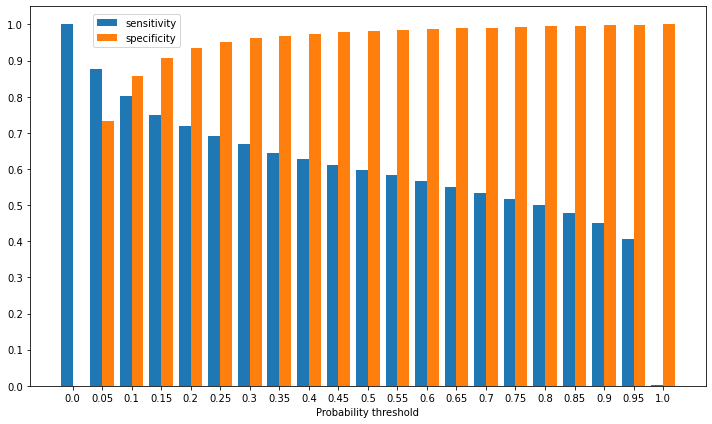

In [9]:
plt.figure(figsize=(10,6))
x = np.round(np.linspace(0.0, 1.0, 21), decimals=2)
width = 0.4
plt.bar(np.arange(len(x))-width/2, sensitivity, width=width, label='sensitivity')
plt.bar(np.arange(len(x))+width/2, specificity, width=width, label='specificity')
plt.xlabel('Probability threshold')
plt.xticks(ticks=np.arange(len(x)), labels=x)
plt.yticks(ticks=np.linspace(0., 1., 11))
plt.legend(bbox_to_anchor=(0.23, 0.88))
plt.tight_layout()
plt.show()

## Draw ROC Plot

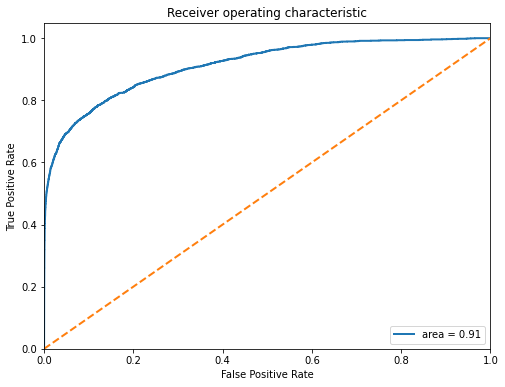

In [10]:
# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_trues, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, lw=lw, 
         label='area = {:0.2f}'.format(roc_auc))
plt.plot([0, 1], [0, 1], lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

## Draw t-SNE Plot

In [5]:
test_features = np.load(feature_dir+'/test_features.npy')
print(test_features.shape)
test_labels = np.load(feature_dir+'/test_labels.npy')
print(test_labels.shape)

(26836, 512)
(26836,)


In [6]:
tsne = TSNE(n_components=2, perplexity=50, learning_rate=500, init='pca', verbose=1, random_state=0)

In [7]:
test_features_embedded = tsne.fit_transform(test_features)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 26836 samples in 0.006s...
[t-SNE] Computed neighbors for 26836 samples in 12.802s...
[t-SNE] Computed conditional probabilities for sample 1000 / 26836
[t-SNE] Computed conditional probabilities for sample 2000 / 26836
[t-SNE] Computed conditional probabilities for sample 3000 / 26836
[t-SNE] Computed conditional probabilities for sample 4000 / 26836
[t-SNE] Computed conditional probabilities for sample 5000 / 26836
[t-SNE] Computed conditional probabilities for sample 6000 / 26836
[t-SNE] Computed conditional probabilities for sample 7000 / 26836
[t-SNE] Computed conditional probabilities for sample 8000 / 26836
[t-SNE] Computed conditional probabilities for sample 9000 / 26836
[t-SNE] Computed conditional probabilities for sample 10000 / 26836
[t-SNE] Computed conditional probabilities for sample 11000 / 26836
[t-SNE] Computed conditional probabilities for sample 12000 / 26836
[t-SNE] Computed conditional probabilities for s

In [8]:
test_features_embedded.shape

(26836, 2)

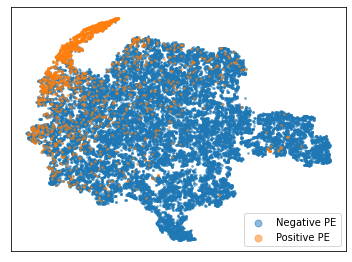

In [29]:
plt.figure(figsize=(6, 4.5))
plt.scatter(test_features_embedded[test_labels==0][:, 0], 
            test_features_embedded[test_labels==0][:, 1], 
            s=3, alpha=0.5, label='Negative PE')
plt.scatter(test_features_embedded[test_labels==1][:, 0], 
            test_features_embedded[test_labels==1][:, 1], 
            s=3, alpha=0.5, label='Positive PE')
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.legend(markerscale=4, loc='lower right')
# plt.title('TSNE of Extracted Features', fontsize=12)
plt.savefig('plot_tsne.jpg', dpi=300)
plt.show()

## Calculate Manhattan distance

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [14]:
test_features_tensor = torch.from_numpy(test_features).float().to('cuda:5')

In [15]:
test_features_embedded_tensor = torch.from_numpy(test_features_embedded).float().to('cuda:5')

In [16]:
test_labels_tensor = torch.from_numpy(test_labels).bool().to('cuda:5')

In [17]:
center_pos = test_features_tensor[test_labels_tensor].mean(dim=0, keepdim=True)
distance_pos = torch.cdist(test_features_tensor[test_labels_tensor], center_pos, p=1).mean()

In [18]:
distance_pos

tensor(70.1536, device='cuda:5')

In [19]:
center_neg = test_features_tensor[~test_labels_tensor].mean(dim=0, keepdim=True)
distance_neg = torch.cdist(test_features_tensor[~test_labels_tensor], center_neg, p=1).mean()

In [20]:
distance_neg

tensor(75.7024, device='cuda:5')

In [21]:
distance = torch.cdist(center_pos, center_neg, p=1).mean()

In [22]:
distance

tensor(97.2102, device='cuda:5')